In [1]:
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns

sns.set(context='notebook', font_scale=1.2, rc={'figure.figsize': (12, 5)})
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

RANDOM_SEED = 8927
np.random.seed(286)

# Helper function
def stdz(series: pd.Series):
    """Standardize the given pandas Series"""
    return (series - series.mean())/series.std()

### 12E1.
*Which of the following priors will produce more shrinkage in the estimates?*

- $\alpha_{TANK} \sim Normal(0, 1)$
- $\alpha_{TANK} \sim Normal(0, 2)$

The first option will produce more shrinkage, because the prior is more concentrated: the standard deviation is smaller, so the density piles up more mass around zero and will pull extreme values closer to zero.

### 12E2.
*Make the following model into a multilevel model:*

$y_{i} \sim Binomial(1, p_{i})$

$logit(p_{i}) = \alpha_{GROUP[i]} + \beta x_{i}$

$\alpha_{GROUP} \sim Normal(0, 10)$

$\beta \sim Normal(0, 1)$

All that is really required to convert the model to a multilevel model is to take the prior for the vector of intercepts, $\alpha_{GROUP}$, and make it adaptive. This means we define parameters for its mean and standard deviation. Then we assign these two new parameters their own priors, *hyperpriors*. This is what it looks like:

$y_{i} \sim Binomial(1, p_{i})$

$logit(p_{i}) = \alpha_{GROUP[i]} + \beta x_{i}$

$\alpha_{GROUP} \sim Normal(\mu_{\alpha}, \sigma_{\alpha})$

$\beta \sim Normal(0, 1)$

$\mu_{\alpha} \sim Normal(0, 10)$

$\sigma_{\alpha} \sim HalfCauchy(1)$

The exact hyperpriors you assign don’t matter here. Since this problem has no data context, it isn’t really possible to say what sensible priors would be. Note also that an exponential prior on $\sigma_{\alpha}$ is just as sensible, absent context, as the half-Cauchy prior.

### 12E3.
*Make the following model into a multilevel model:*

$y_{i} \sim Normal(\mu_{i}, \sigma)$

$\mu_{i} = \alpha_{GROUP[i]} + \beta x_{i}$

$\alpha_{GROUP} \sim Normal(0, 10)$

$\beta \sim Normal(0, 1)$

$\sigma \sim HalfCauchy(2)$

This is very similar to the previous problem. The only trick here is to notice that there is already a standard deviation parameter, σ. But that standard deviation is for the residuals, at the top level. We’ll need yet another standard deviation for the varying intercepts:

$y_{i} \sim Normal(\mu_{i}, \sigma)$

$\mu_{i} = \alpha_{GROUP[i]} + \beta x_{i}$

$\alpha_{GROUP} \sim Normal(\mu_{\alpha}, \sigma_{\alpha})$

$\beta \sim Normal(0, 1)$

$\sigma \sim HalfCauchy(2)$

$\mu_{\alpha} \sim Normal(0, 10)$

$\sigma_{\alpha} \sim HalfCauchy(1)$

### 12E4.
*Write an example mathematical model formula for a Poisson regression with varying intercepts*

You can just copy the answer from problem 12E2 and swap out the binomial likelihood for a Poisson, taking care to change the link function from logit to log:

$y_{i} \sim Poisson(\lambda_{i})$

$log(\lambda_{i}) = \alpha_{GROUP[i]} + \beta x_{i}$

$\alpha_{GROUP} \sim Normal(\mu_{\alpha}, \sigma_{\alpha})$

$\beta \sim Normal(0, 1)$

$\mu_{\alpha} \sim Normal(0, 10)$

$\sigma_{\alpha} \sim HalfCauchy(1)$

Under the hood, all multilevel models are alike. It doesn’t matter which likelihood function rests at the top. Take care, however, to reconsider priors. The scale of the data and parameters is likely quite different for a Poisson model. Absent any particular context in this problem, you can’t recommend better priors. But in real work, it’s good to think about reasonable values and provide regularizing priors on the relevant scale.

### 12E5.
*Write an example mathematical model formula for a Poisson regression with two different kinds of varying intercepts - a cross-classified model*

The cross-classified model adds another varying intercept type. This is no harder than duplicating the original varying intercepts structure. But you have to take care now not to over-parameterize the model by having a hyperprior mean for both intercept types. You can do this by just assigning one of the adaptive priors a mean of zero. Suppose for example that the second cluster type is day:

$y_{i} \sim Poisson(\lambda_{i})$

$log(\lambda_{i}) = \alpha_{GROUP[i]} + \alpha_{DAY[i]} + \beta x_{i}$

$\alpha_{GROUP} \sim Normal(\mu_{\alpha}, \sigma_{GROUP})$

$\alpha_{DAY} \sim Normal(0, \sigma_{DAY})$

$\beta \sim Normal(0, 1)$

$\mu_{\alpha} \sim Normal(0, 10)$

$\sigma_{GROUP}, \sigma_{DAY} \sim HalfCauchy(1)$

Or you can just pull the mean intercept out of both priors and put it in the linear model:

$y_{i} \sim Poisson(\lambda_{i})$

$log(\lambda_{i}) = \alpha + \alpha_{GROUP[i]} + \alpha_{DAY[i]} + \beta x_{i}$

$\alpha \sim Normal(0, 10)$

$\alpha_{GROUP} \sim Normal(0, \sigma_{GROUP})$

$\alpha_{DAY} \sim Normal(0, \sigma_{DAY})$

$\beta \sim Normal(0, 1)$

$\sigma_{GROUP}, \sigma_{DAY} \sim HalfCauchy(1)$

These are exactly the same model. Although as you’ll see later in Chapter 13, these different forms might be more or less efficient in sampling.

### 12M1.
*Revisit the Reed frog survival data, reedfrogs.csv, and add the $predation$ and $size$ treatment variables to the varying intercepts model. Consider models with either main effect alone, both main effects, as well as a model including both and their interaction. Instead of focusing on inferences about these two predictor variables, focus on the inferred variation across tanks. Explain why it changes as it does across models.*

In [2]:
frogs = pd.read_csv('../Data/reedfrogs.csv', sep=",")

# Switch predictors to dummies
frogs["size"] = pd.Categorical(frogs["size"]).reorder_categories(["small", "big"]).codes
frogs["pred"] = pd.Categorical(frogs["pred"]).codes

# make the tank cluster variable
tank = np.arange(frogs.shape[0])

print(frogs.shape)
frogs.head(8)

(48, 5)


,density,pred,size,surv,propsurv
0,10,0,1,9,0.9
1,10,0,1,10,1.0
2,10,0,1,7,0.7
3,10,0,1,10,1.0
4,10,0,0,9,0.9
5,10,0,0,9,0.9
6,10,0,0,10,1.0
7,10,0,0,9,0.9


In [3]:
frogs.describe()

,density,pred,size,surv,propsurv
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,23.333333,0.500000,0.500000,16.312500,0.721607
std,10.382746,0.505291,0.505291,9.884775,0.266416
min,10.000000,0.000000,0.000000,4.000000,0.114286
25%,10.000000,0.000000,0.000000,9.000000,0.496429
50%,25.000000,0.500000,0.500000,12.500000,0.885714
75%,35.000000,1.000000,1.000000,23.000000,0.920000
max,35.000000,1.000000,1.000000,35.000000,1.000000


In [4]:
pred = frogs["pred"].values
size = frogs["size"].values
n_samples, tuning = 1000, 2000

with pm.Model() as m_itcpt:
    a = pm.Normal('a', 0., 10.)
    sigma_tank = pm.HalfCauchy('sigma_tank', 1.)
    
    a_tank = pm.Normal('a_tank', a, sigma_tank, shape=frogs.shape[0])
    
    p = pm.math.invlogit(a_tank[tank])
    
    surv = pm.Binomial('surv', n=frogs.density, p=p, observed=frogs.surv)
    
    trace_itcpt = pm.sample(n_samples, tune=tuning, cores=2)

with pm.Model() as m_p:
    a = pm.Normal('a', 0., 10.)
    sigma_tank = pm.HalfCauchy('sigma_tank', 1.)
    
    a_tank = pm.Normal('a_tank', a, sigma_tank, shape=frogs.shape[0])
    bp = pm.Normal('bp', 0., 1.)
    
    p = pm.math.invlogit(a_tank[tank] + bp*pred)
    
    surv = pm.Binomial('surv', n=frogs.density, p=p, observed=frogs.surv)
    
    trace_p = pm.sample(n_samples, tune=tuning, cores=2)
    
with pm.Model() as m_s:
    a = pm.Normal('a', 0., 10.)
    sigma_tank = pm.HalfCauchy('sigma_tank', 1.)
    
    a_tank = pm.Normal('a_tank', a, sigma_tank, shape=frogs.shape[0])
    bs = pm.Normal('bs', 0., 1.)
    
    p = pm.math.invlogit(a_tank[tank] + bs*size)
    
    surv = pm.Binomial('surv', n=frogs.density, p=p, observed=frogs.surv)
    
    trace_s = pm.sample(n_samples, tune=tuning, cores=2)
    
with pm.Model() as m_p_s:
    a = pm.Normal('a', 0., 10.)
    sigma_tank = pm.HalfCauchy('sigma_tank', 1.)
    
    a_tank = pm.Normal('a_tank', a, sigma_tank, shape=frogs.shape[0])
    bp = pm.Normal('bp', 0., 1.)
    bs = pm.Normal('bs', 0., 1.)
    
    p = pm.math.invlogit(a_tank[tank] + bp*pred + bs*size)
    
    surv = pm.Binomial('surv', n=frogs.density, p=p, observed=frogs.surv)
    
    trace_p_s = pm.sample(n_samples, tune=tuning, cores=2)
    
with pm.Model() as m_p_s_ps:
    a = pm.Normal('a', 0., 10.)
    sigma_tank = pm.HalfCauchy('sigma_tank', 1.)
    
    a_tank = pm.Normal('a_tank', a, sigma_tank, shape=frogs.shape[0])
    bp = pm.Normal('bp', 0., 1.)
    bs = pm.Normal('bs', 0., 1.)
    bps = pm.Normal('bps', 0., 1.)
    
    p = pm.math.invlogit(a_tank[tank] + bp*pred + bs*size + bps*pred*size)
    
    surv = pm.Binomial('surv', n=frogs.density, p=p, observed=frogs.surv)
    
    trace_p_s_ps = pm.sample(n_samples, tune=tuning, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_tank, sigma_tank, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:18<00:00, 328.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, a_tank, sigma_tank, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:26<00:00, 227.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bs, a_tank, sigma_tank, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:28<00:00, 213.30draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bs, bp, a_tank, sigma_tank, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:36<00:00, 165.74draws/s]
The number of e

Now we’d like to inspect how the estimated variation across tanks changes from model to model. This means comparing posterior distributions for $\sigma_{tank}$ across the models:

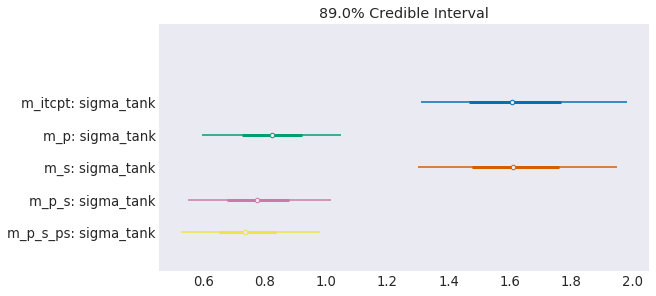

In [5]:
az.plot_forest([trace_itcpt, trace_p, trace_s, trace_p_s, trace_p_s_ps], 
               model_names=["m_itcpt", "m_p", "m_s", "m_p_s", "m_p_s_ps"], 
               var_names=["sigma_tank"], credible_interval=.89, figsize=(9,4), combined=True);

Note that adding a predictor always decreased the posterior mean variation across tanks. Why? Because the predictors are, well, predicting variation. This leaves less variation for the varying intercepts to mop up. In theory, if we had in the form of predictor variables all of the relevant information that determined the survival outcomes, there would be zero variation across tanks.

You might also notice that the $size$ treatment variable reduces the variation much less than does $predation$. The predictor $size$, in these models, doesn’t help prediction very much, so accounting for it has minimal impact on the estimated variation across tanks.

### 12M2.
*Compare the models you fit just above, using WAIC. Can you reconcile the differences in WAIC with the posterior distributions of the models?*

In [6]:
az.compare({"m_itcpt": trace_itcpt, "m_p": trace_p, "m_s": trace_s, "m_p_s": trace_p_s, "m_p_s_ps": trace_p_s_ps}, 
           method="pseudo-BMA")

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/anaconda/envs/stat-rethink-pym

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_p_s_ps,199.15,18.9342,0,0.228143,9.4278,0,True,deviance
m_p,199.157,19.3755,0.00704042,0.227341,9.0807,3.56207,True,deviance
m_p_s,199.427,19.1227,0.276655,0.19867,8.64243,2.65081,True,deviance
m_itcpt,199.456,20.7163,0.305857,0.19579,7.22938,6.13666,True,deviance
m_s,199.988,20.7946,0.837928,0.150056,7.19873,6.31389,True,deviance


The models are extremely close, but m_s seems to be the last one, suggesting that $size$ accounts for very little. Can we see this in the coefficients?

In [7]:
def get_coefs(est_summary: pd.DataFrame) -> dict:
    mean_est = est_summary["mean"].to_dict()
    coefs = {}
        
    coefs['sigma_tank'] = mean_est.get('sigma_tank', np.nan)
    coefs['bp'] = mean_est.get('bp', np.nan)
    coefs['bs'] = mean_est.get('bs', np.nan)
    coefs['bps'] = mean_est.get('bps', np.nan)
        
    return coefs

In [8]:
pd.DataFrame.from_dict({"m_itcpt": get_coefs(az.summary(trace_itcpt, credible_interval=0.89)), 
                       "m_p": get_coefs(az.summary(trace_p, credible_interval=0.89)),
                       "m_s": get_coefs(az.summary(trace_s, credible_interval=0.89)),
                       "m_p_s": get_coefs(az.summary(trace_p_s, credible_interval=0.89)),
                       "m_p_s_ps": get_coefs(az.summary(trace_p_s_ps, credible_interval=0.89))})

,m_itcpt,m_p,m_s,m_p_s,m_p_s_ps
bp,NaN,-2.436,NaN,-2.437,-1.966
bps,NaN,NaN,NaN,NaN,-1.066
bs,NaN,NaN,-0.380,-0.455,0.139
sigma_tank,1.625,0.834,1.624,0.785,0.745


The posterior means for $b_{s}$ are smaller in absolute value than those for $b_{p}$. This is consistent with the WAIC comparison. In fact, the standard deviations on these coefficients are big enough that the $b_{s}$ posterior distributions overlap zero quite a bit. Consider for example the model m_s:

In [9]:
az.summary(trace_s, var_names=["a", "bs", "sigma_tank"], credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.575,0.345,1.017,2.127,0.013,0.009,671.0,671.0,670.0,1148.0,1.0
bs,-0.380,0.452,-1.055,0.360,0.021,0.015,472.0,472.0,473.0,753.0,1.0
sigma_tank,1.624,0.212,1.300,1.950,0.005,0.004,1758.0,1722.0,1797.0,1634.0,1.0


But before you conclude that tadpole size doesn’t matter, remember that other models, perhaps including additional predictors, might find new life for $size$. Inference is always conditional on the model.

### 12M3.
*Re-estimate the basic Reed frog varying intercept model, but now using a Cauchy distribution in place of the Gaussian distribution for the varying intercepts. That is, fit this model:*

$s_{i} \sim Binomial(n_{i}, p_{i})$

$logit(p_{i}) = \alpha_{TANK[i]}$

$\alpha_{TANK} \sim Cauchy(\alpha, \sigma)$

$\alpha \sim Normal(0, 1)$

$\sigma \sim HalfCauchy(1)$

*Compare the posterior means of the intercepts, $\alpha_{TANK}$, to the posterior means produced in the chapter, using the customary Gaussian prior. Can you explain the pattern of differences?*

In [10]:
with pm.Model() as m_itcpt_cauch:
    a = pm.Normal('a', 0., 1.)
    sigma_tank = pm.HalfCauchy('sigma_tank', 1.)
    
    a_tank = pm.Cauchy('a_tank', a, sigma_tank, shape=frogs.shape[0])
    
    p = pm.math.invlogit(a_tank[tank])
    
    surv = pm.Binomial('surv', n=frogs.density, p=p, observed=frogs.surv)
    
    trace_itcpt_cauch = pm.sample(3000, tune=3000, cores=2, nuts_kwargs={"target_accept": .99})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_tank, sigma_tank, a]
Sampling 2 chains: 100%|██████████| 12000/12000 [08:45<00:00, 20.70draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


You might have some trouble sampling efficiently from this posterior, on account of the long tails of the Cauchy. This results in the intercepts a_tank being poorly identifed. You saw a simple example of this problem in Chapter 8, when you met MCMC and learned about diagnosing bad chains. To help the sampler explore the space more efficiently, we've increase the target_accept ratio to 0.99. This topic will come up in more detail in Chapter 13. In any event, be sure to check the chains carefully and sample more if you need to.

The problem asked you to compare the posterior means of the a_tank parameters. Plotting the posterior means will be a lot more meaningful than just looking at the values:

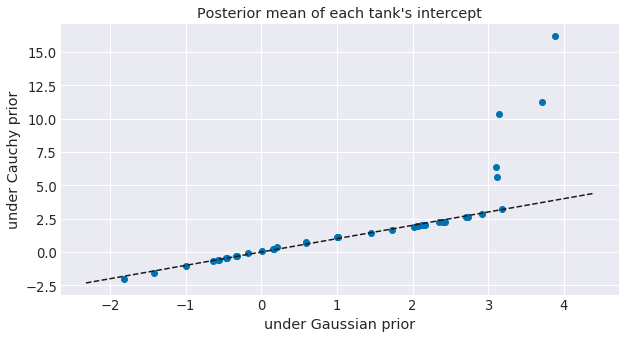

In [11]:
post_itcpt = pm.trace_to_dataframe(trace_itcpt)
a_tank_m = post_itcpt.drop(["a", "sigma_tank"], axis=1).mean()

post_itcpt_cauch = pm.trace_to_dataframe(trace_itcpt_cauch)
a_tank_mC = post_itcpt_cauch.drop(["a", "sigma_tank"], axis=1).mean()

plt.figure(figsize=(10,5))
plt.scatter(x=a_tank_m, y=a_tank_mC)
plt.plot([a_tank_m.min()-0.5, a_tank_m.max()+0.5], [a_tank_m.min()-0.5, a_tank_m.max()+0.5], "k--")
plt.xlabel("under Gaussian prior")
plt.ylabel("under Cauchy prior")
plt.title("Posterior mean of each tank's intercept");

The dashed line shows the values for which the intercepts are equal in the two models. You can see that for the majority of tank intercepts, the Cauchy model actually produces posterior means that are essentially the same as those from the Gaussian model. But the large intercepts, under the Gaussian prior, are very much more extreme under the Cauchy prior. 

For those tanks on the righthand side of the plot, all of the tadpoles survived. So using only the data from each tank alone, the log-odds of survival are infinite. The adaptive prior applies pooling that shrinks those log-odds inwards from infinity, thankfully. But the Gaussian prior causes more shrinkage of the extreme values than the Cauchy prior does. That is what accounts for those 5 extreme points on the right of the plot above.

### 12M4.
*Fit the following cross-classified multilevel model to the chimpanzees data:*

$L_{i} \sim Binomial(1, p_{i})$

$logit(p_{i}) = \alpha_{ACTOR[i]} + \alpha_{BLOCK[i]} + (\beta_{P} + \beta_{PC} C_{i}) P_{i}$

$\alpha_{ACTOR} \sim Normal(\alpha, \sigma_{ACTOR})$

$\alpha_{BLOCK} \sim Normal(\gamma, \sigma_{BLOCK})$

$\alpha, \gamma, \beta_{P}, \beta_{PC} \sim Normal(0, 10)$

$\sigma_{ACTOR}, \sigma_{BLOCK} \sim HalfCauchy(1)$

*Compare the posterior distribution to that produced by the similar cross-classified model from the chapter. Also compare the number of effective samples. Can you explain the differences?*

In [12]:
chimp = pd.read_csv('../Data/chimpanzees.csv', sep=";")

# we change "actor" and "block" to zero-index
chimp.actor = (chimp.actor - 1).astype(int)
chimp.block = (chimp.block - 1).astype(int)

Nactor = len(chimp.actor.unique())
Nblock = len(chimp.block.unique())

chimp.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,0,NaN,0,0,2,0,1,0
1,0,NaN,0,0,4,0,0,1
2,0,NaN,0,0,6,1,0,0
3,0,NaN,0,0,8,0,1,0
4,0,NaN,0,0,10,1,1,1


In [13]:
with pm.Model() as m_chapter:
    sigma_actor = pm.HalfCauchy('sigma_actor', 1.)
    sigma_block = pm.HalfCauchy('sigma_block', 1.)
    
    a_actor = pm.Normal('a_actor', 0., sigma_actor, shape=Nactor)
    a_block = pm.Normal('a_block', 0., sigma_block, shape=Nblock)
    a = pm.Normal('a', 0., 10.)
    bp = pm.Normal('bp', 0., 10.)
    bpc = pm.Normal('bpc', 0., 10.)
    
    p = pm.math.invlogit(a + a_actor[chimp.actor.values] + a_block[chimp.block.values]
                         + (bp + bpc * chimp.condition) * chimp.prosoc_left)
    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=chimp.pulled_left)

    trace_chapter= pm.sample(1000, tune=3000, cores=2)
    
with pm.Model() as m_exerc:
    alpha = pm.Normal("alpha", 0., 10.)
    gamma = pm.Normal("gamma", 0., 10.)
    sigma_actor = pm.HalfCauchy('sigma_actor', 1.)
    sigma_block = pm.HalfCauchy('sigma_block', 1.)
    
    a_actor = pm.Normal('a_actor', alpha, sigma_actor, shape=Nactor)
    a_block = pm.Normal('a_block', gamma, sigma_block, shape=Nblock)
    bp = pm.Normal('bp', 0., 10.)
    bpc = pm.Normal('bpc', 0., 10.)
    
    p = pm.math.invlogit(a_actor[chimp.actor.values] + a_block[chimp.block.values]
                         + (bp + bpc * chimp.condition) * chimp.prosoc_left)
    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=chimp.pulled_left)

    trace_exerc= pm.sample(1000, tune=3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpc, bp, a, a_block, a_actor, sigma_block, sigma_actor]
Sampling 2 chains: 100%|██████████| 8000/8000 [01:46<00:00, 75.29draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7200560504221213, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpc, bp, a_block, a_actor, sigma_block, sigma_actor, gamma, alpha]
Sampling 2 chains: 100%|██████████| 8000/8000 [10:40<00:00, 12.49draws/s]
There were 144 divergences after tuning. Increase `target_accept` or reparameterize.
There were 417 divergences after tuning. Increase `target_accept` or reparameterize.

This is much like the model in the chapter, just with the two varying intercept means inside the two priors, instead of one mean outside both priors (inside the linear model). Since there are two parameters for the means, one inside each adaptive prior, this model is over-parameterized: an infinite number of different values of $\alpha$ and $\gamma$ will produce the same sum $\alpha + \gamma$. In other words, the $\gamma$ parameter is redundant. 

This will produce a poorly-identified posterior. It’s best to avoid specifying a model like this. As a matter of fact, you probably noticed the second model took a lot more time to sample than the first one (about 10x more time), which is usually a sign of a poorly parametrized model. Remember the folk theorem of statistical computing: "*When you have computational problems, often there’s a problem with your model*".

Now let's look at each model's parameters:

In [14]:
az.summary(trace_chapter, var_names=["a", "bp", "bpc", "sigma_actor", "sigma_block"], credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.449,0.899,-0.895,1.746,0.046,0.032,388.0,388.0,407.0,526.0,1.00
bp,0.830,0.272,0.401,1.242,0.008,0.005,1280.0,1280.0,1274.0,947.0,1.00
bpc,-0.148,0.314,-0.732,0.257,0.011,0.012,749.0,346.0,717.0,175.0,1.00
sigma_actor,2.233,0.882,0.938,3.315,0.037,0.029,556.0,478.0,736.0,760.0,1.00
sigma_block,0.227,0.178,0.014,0.446,0.011,0.008,242.0,242.0,151.0,58.0,1.02


In [15]:
az.summary(trace_exerc, var_names=["alpha", "gamma", "bp", "bpc", "sigma_actor", "sigma_block"], credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.382,5.774,-9.789,9.397,0.505,0.373,131.0,120.0,124.0,269.0,1.07
gamma,-0.929,5.719,-9.213,9.801,0.509,0.403,126.0,101.0,123.0,251.0,1.15
bp,0.808,0.234,0.419,1.177,0.016,0.013,217.0,172.0,226.0,468.0,1.12
bpc,-0.184,0.259,-0.587,0.258,0.015,0.011,297.0,297.0,268.0,546.0,1.08
sigma_actor,3.308,2.036,1.195,6.841,1.011,0.806,4.0,4.0,6.0,30.0,1.27
sigma_block,0.309,0.166,0.148,0.488,0.046,0.033,13.0,13.0,6.0,31.0,1.27


Look at these awful effective sample sizes (ess) and R-hat values for trace_exerc! In a nutshell, the new model (m_exerc) samples quite poorly. This is what happens when you over-parameterize the intercept. Notice however that the inferences about the slopes are practically identical. So even though the over-parameterized model is inefficient, it has identified the slope parameters.

### 12H1.
*In 1980, a typical Bengali woman could have 5 or more children in her lifetime. By the year 2000, a typical Bengali woman had only 2 or 3 children. You're going to look at a historical set of data, when contraception was widely available but many families chose not to use it. These data reside in bangladesh.csv and come from the 1988 Bangladesh Fertility Survey. Each row is one of 1934 women. There are six variables, but you can focus on three of them for this practice problem:*

- $district$: ID number of administrative district each woman resided in
- $use.contraception$: An indicator (0/1) of whether the woman was using contraception
- $urban$: An indicator (0/1) of whether the woman lived in a city, as opposed to living in a rural area

*The first thing to do is ensure that the cluster variable, $district$, is a contiguous set of integers. Recall that these values will be index values inside the model. If there are gaps, you’ll have parameters for which there is no data to inform them. Worse, the model probably won’t run. Let's look at the unique values of the $district$ variable:*

In [16]:
d = pd.read_csv('../Data/bangladesh.csv', sep=";")
d.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


In [17]:
d.describe()

,woman,district,use.contraception,living.children,age.centered,urban
count,1934.000000,1934.000000,1934.000000,1934.000000,1934.000000,1934.000000
mean,967.500000,29.353671,0.392451,2.652017,0.002198,0.290589
std,558.442029,17.959835,0.488422,1.242631,9.013244,0.454152
min,1.000000,1.000000,0.000000,1.000000,-13.560000,0.000000
25%,484.250000,14.000000,0.000000,1.000000,-7.559900,0.000000
50%,967.500000,29.000000,0.000000,3.000000,-1.559900,0.000000
75%,1450.750000,45.000000,1.000000,4.000000,6.440000,1.000000
max,1934.000000,61.000000,1.000000,4.000000,19.440000,1.000000


In [18]:
d.district.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 55, 56, 57, 58, 59, 60, 61])

District 54 is absent. So $district$ isn’t yet a good index variable, because it’s not contiguous. This is easy to fix. Just make a new variable that is contiguous:

In [19]:
d["district_id"], _ = pd.factorize(d.district, sort=True)
district_id = d.district_id.values
Ndistricts = len(d.district_id.unique())
d.district_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

Now there are 60 values, contiguous integers 0 to 59.

Now, focus on predicting $use.contraception$, clustered by district ID. Fit both (1) a traditional fixed-effects model that uses an index variable for district and (2) a multilevel model with varying intercepts for district. Plot the predicted proportions of women in each district using contraception, for both the fixed-effects model and the varying-effects model. That is, make a plot in which district_id is on the horizontal axis and expected proportion using contraception is on the vertical. Make one plot for each model, or layer them on the same plot, as you prefer. 

How do the models disagree? Can you explain the pattern of disagreement? In particular, can you explain the most extreme cases of disagreement, both why they happen, where they do and why the models reach different inferences?

In [20]:
with pm.Model() as m_fixed:
    a_district = pm.Normal('a_district', 0., 10., shape=Ndistricts)
    
    p = pm.math.invlogit(a_district[district_id])
    
    used = pm.Bernoulli('used', p=p, observed=d["use.contraception"])
    
    trace_fixed = pm.sample(1000, tune=2000, cores=2)

with pm.Model() as m_varying:
    a = pm.Normal('a', 0., 10.)
    sigma_district = pm.Exponential('sigma_district', 1.)
    
    a_district = pm.Normal('a_district', 0., sigma_district, shape=Ndistricts)
    
    p = pm.math.invlogit(a + a_district[district_id])
    
    used = pm.Bernoulli('used', p=p, observed=d["use.contraception"])
    
    trace_varying = pm.sample(1000, tune=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_district]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:48<00:00, 123.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_district, sigma_district, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:38<00:00, 157.21draws/s]


Sampling was smooth and quick, so the traces should be ok. We can confirm by plotting them:

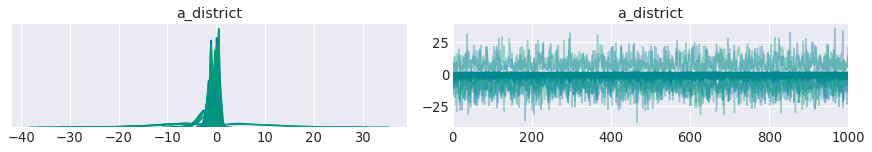

In [21]:
az.plot_trace(trace_fixed, compact=True);

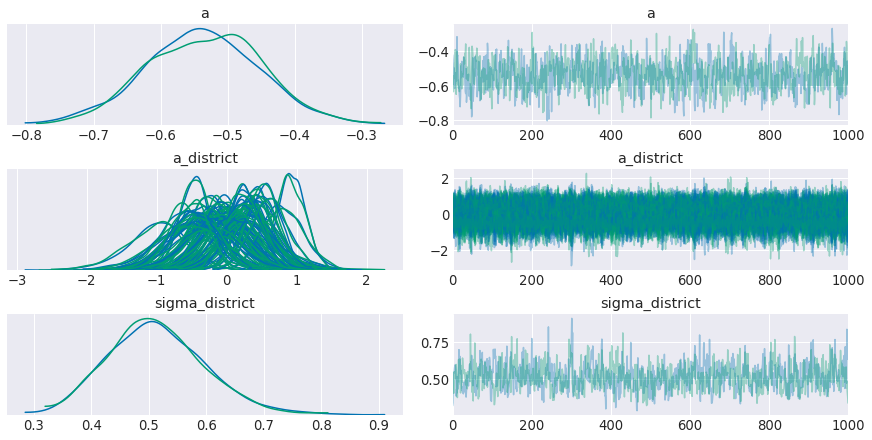

In [22]:
az.plot_trace(trace_varying, compact=True);

The chains are indeed fine. These models have a lot of parameters, so the summary dataframe we are used to is not really convenient here. Let's use forest plots instead:

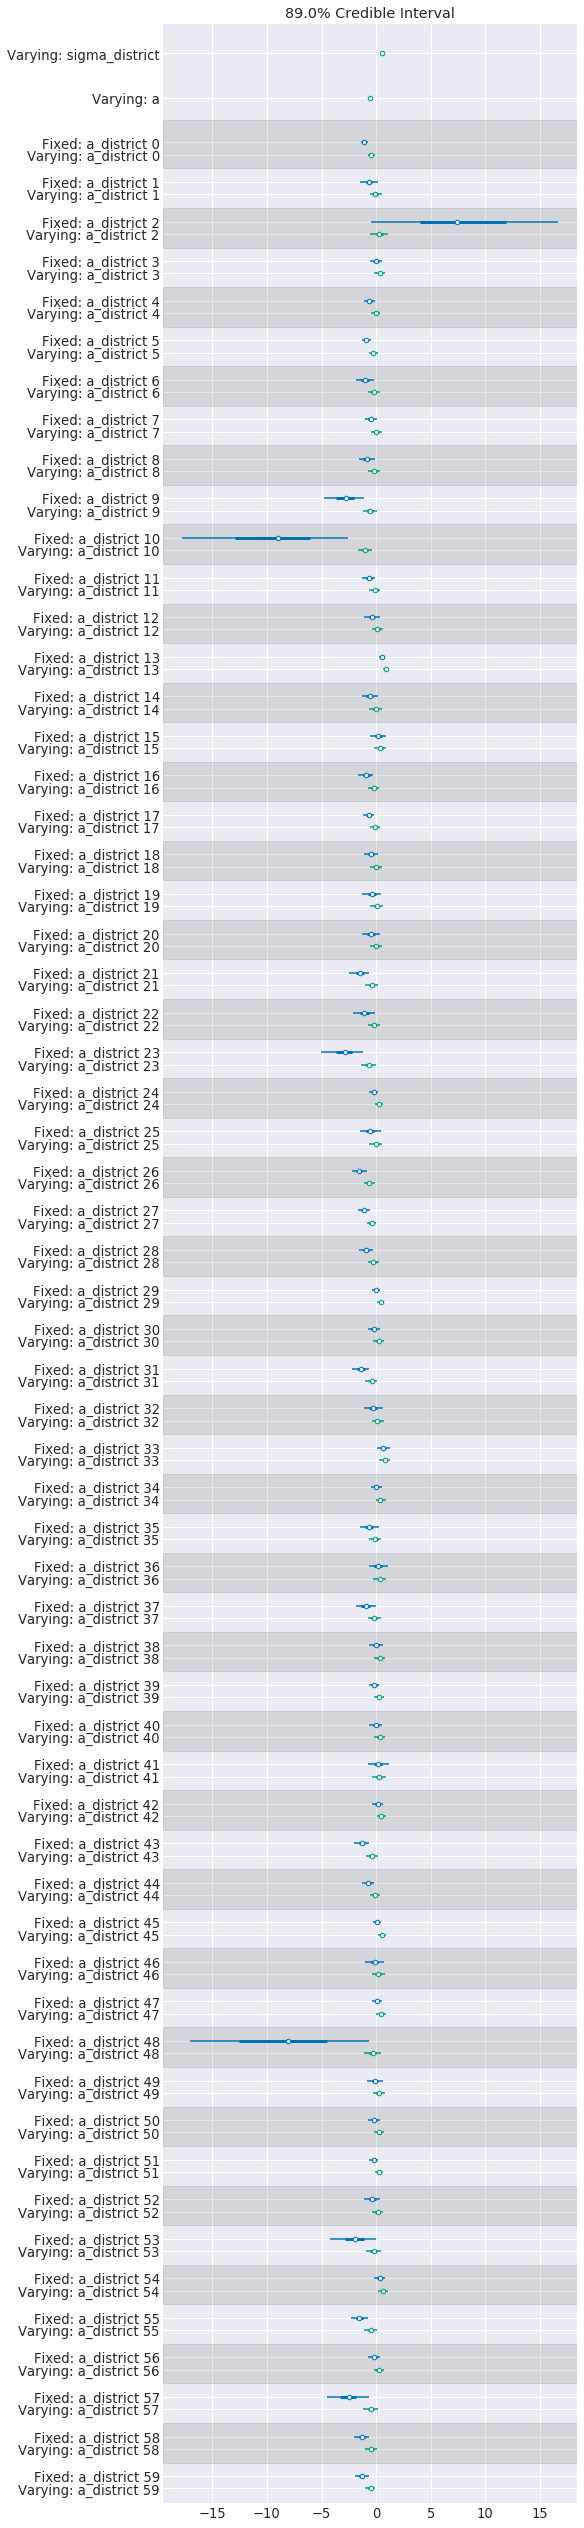

In [23]:
fig, axes = az.plot_forest([trace_fixed, trace_varying], model_names=["Fixed", "Varying"], 
                           credible_interval=0.89, combined=True, figsize=(8,35))
axes[0].grid();

We can already see that some estimates are particularly uncertain in some districts, but only for the fixed-effects model. Chances are these districts are extreme compared to the others, and/or the sample sizes are very small. This would be a case where the varying-effects model's estimates would be better and less volatile in those districts, because it is pooling information - information flows across districts thanks to the higher level common distribution of districts.

In [24]:
post_fixed = pm.trace_to_dataframe(trace_fixed)
p_mean_fixed = sp.special.expit(post_fixed.mean())

post_varying = pm.trace_to_dataframe(trace_varying)
# add a_district to a (because they are offsets of the global intercept), then convert to probabilities with logistic
p_mean_varying = sp.special.expit(post_varying.drop(["a", "sigma_district"], axis=1).add(post_varying["a"], axis="index").mean())
global_a = sp.special.expit(post_varying["a"].mean())

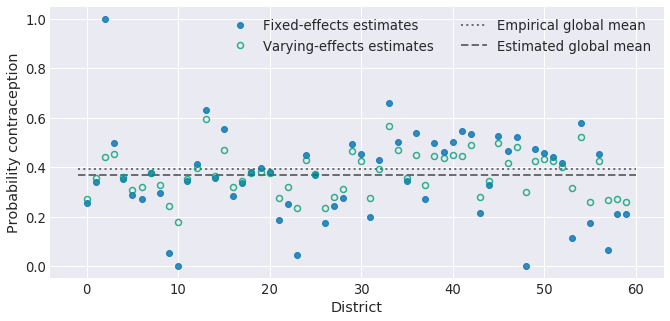

In [25]:
plt.figure(figsize=(11,5))

plt.hlines(d["use.contraception"].mean(), -1, Ndistricts, linestyles="dotted", label="Empirical global mean", alpha=.6, lw=2)
plt.hlines(global_a, -1, Ndistricts, linestyles="dashed", label="Estimated global mean", alpha=.6, lw=2)

plt.plot(np.arange(Ndistricts), p_mean_fixed, "o", ms=6, alpha=.8, label="Fixed-effects estimates")
plt.plot(np.arange(Ndistricts), p_mean_varying, "o", fillstyle="none", ms=6, markeredgewidth=1.5, alpha=.8, label="Varying-effects estimates")

plt.xlabel("District")
plt.ylabel("Probability contraception")
plt.legend(ncol=2);

The blue points are the fixed-effects estimates, and the open green ones are the varying effects. The dotted line is the observed average proportion of women using contraception, in the entire sample. The dashed line is the average proportion of women using contraception, in the entire sample, *as estimated by the varying effects model*. 

Notice first that the green points are always closer to the dashed line, as was the case with the tadpole example in lecture. This results from shrinkage, which results from pooling information. There are cases with rather extreme disagreements, though. The most obvious is district 2, which has a fixed (blue) estimate of 1 but a varying (green) estimate of only 0.44. There are also two districts (10 and 48) for which the fixed estimates are zero, but the varying estimates are 0.18 and 0.30. If you go back to the forest plot above, these are exactly the three districts whose fixed-effects parameters were both far from zero and very uncertain.

So what’s going on here? As we suspected, these districts presented extreme results: either all sampled women used contraception or none did. As a result, the fixed-effects estimates were silly. The varying-effects model was able to produce more rational estimates, because it pooled information from other districts.

But note that the intensity of pooling was different for these three extreme districts. As we intuited too, depending upon how many women were sampled in each district, there was more or less shrinkage (pooling) towards the grand mean. So for example in the case of district 2, there were only 2 women in the sample, and so there is a lot of distance between the blue and green points. In contrast, district 10 had 21 women in the sample, and so while pooling pulls the estimate off of zero to 0.18, it doesn’t pull it nearly as far as district 2.

Another way to think of this phenomenon is to view the same estimates arranged by number of women in the sampled district, on the horizontal axis. Then on the vertical we can plot the distance (absolute value of the difference) between the fixed and varying estimates. Here’s what that looks like:

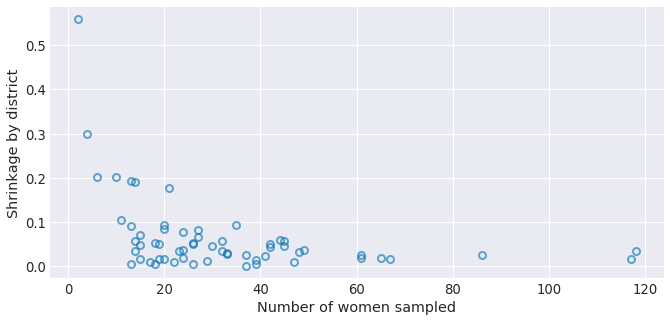

In [26]:
nbr_women = d.groupby("district_id").count()["woman"]
abs_dist = (p_mean_fixed - p_mean_varying).abs()

plt.figure(figsize=(11,5))
plt.plot(nbr_women, abs_dist, 'o', fillstyle="none", ms=7, markeredgewidth=2, alpha=.6)
plt.xlabel("Number of women sampled")
plt.ylabel("Shrinkage by district");

You can think of the vertical axis as being the amount of shrinkage. The districts with fewer women sampled show a lot more shrinkage, because there is less information in them. As a result, they are expected to overfit more, and so they are shrunk more towards the overall mean.

### 12H2.
*Return to the Trolley data from Chapter 11. Define and fit a varying intercepts model for these data. By this I mean to add an intercept parameter for the individuals to the linear model. Cluster the varying intercepts on individual participants, as indicated by the unique values in the id variable. Include $action$, $intention$, and $contact$ as before. Compare the varying intercepts model and a model that ignores individuals, using both WAIC/LOO and posterior predictions. What is the impact of individual variation in these data?*

**This will be adressed in a later pull request, as there is currently an issue with PyMC's OrderedLogistic implementation**

### 12H3.
*The Trolley data are also clustered by $story$, which indicates a unique narrative for each vignette. Define and fit a cross-classified varying intercepts model with both $id$ and $story$. Use the same ordinary terms as in the previous problem. Compare this model to the previous models. What do you infer about the impact of different stories on responses?*

**This will be adressed in a later pull request, as there is currently an issue with PyMC's OrderedLogistic implementation**

In [27]:
import sys, IPython, scipy, matplotlib, platform
print(f"This notebook was created on a computer {platform.machine()}, using: "
      f"\nPython {sys.version[:5]}\nIPython {IPython.__version__}\nPyMC3 {pm.__version__}\nArviz {az.__version__}\nNumPy {np.__version__}"
      f"\nPandas {pd.__version__}\nSciPy {scipy.__version__}\nMatplotlib {matplotlib.__version__}\n")

This notebook was created on a computer x86_64, using: 
Python 3.7.3
IPython 7.5.0
PyMC3 3.7
Arviz 0.4.1
NumPy 1.16.3
Pandas 0.24.2
SciPy 1.2.1
Matplotlib 3.0.3

